In [1]:
!pip install torchinfo

In [2]:
import torch
import torchvision
from torchvision import transforms
import requests
from io import BytesIO
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
from torchinfo import summary

In [3]:
model = torchvision.models.mobilenet_v3_small(pretrained=True)

In [4]:
image_url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"

In [5]:
r = requests.get(image_url)

In [6]:
original_image = Image.open(BytesIO(r.content))

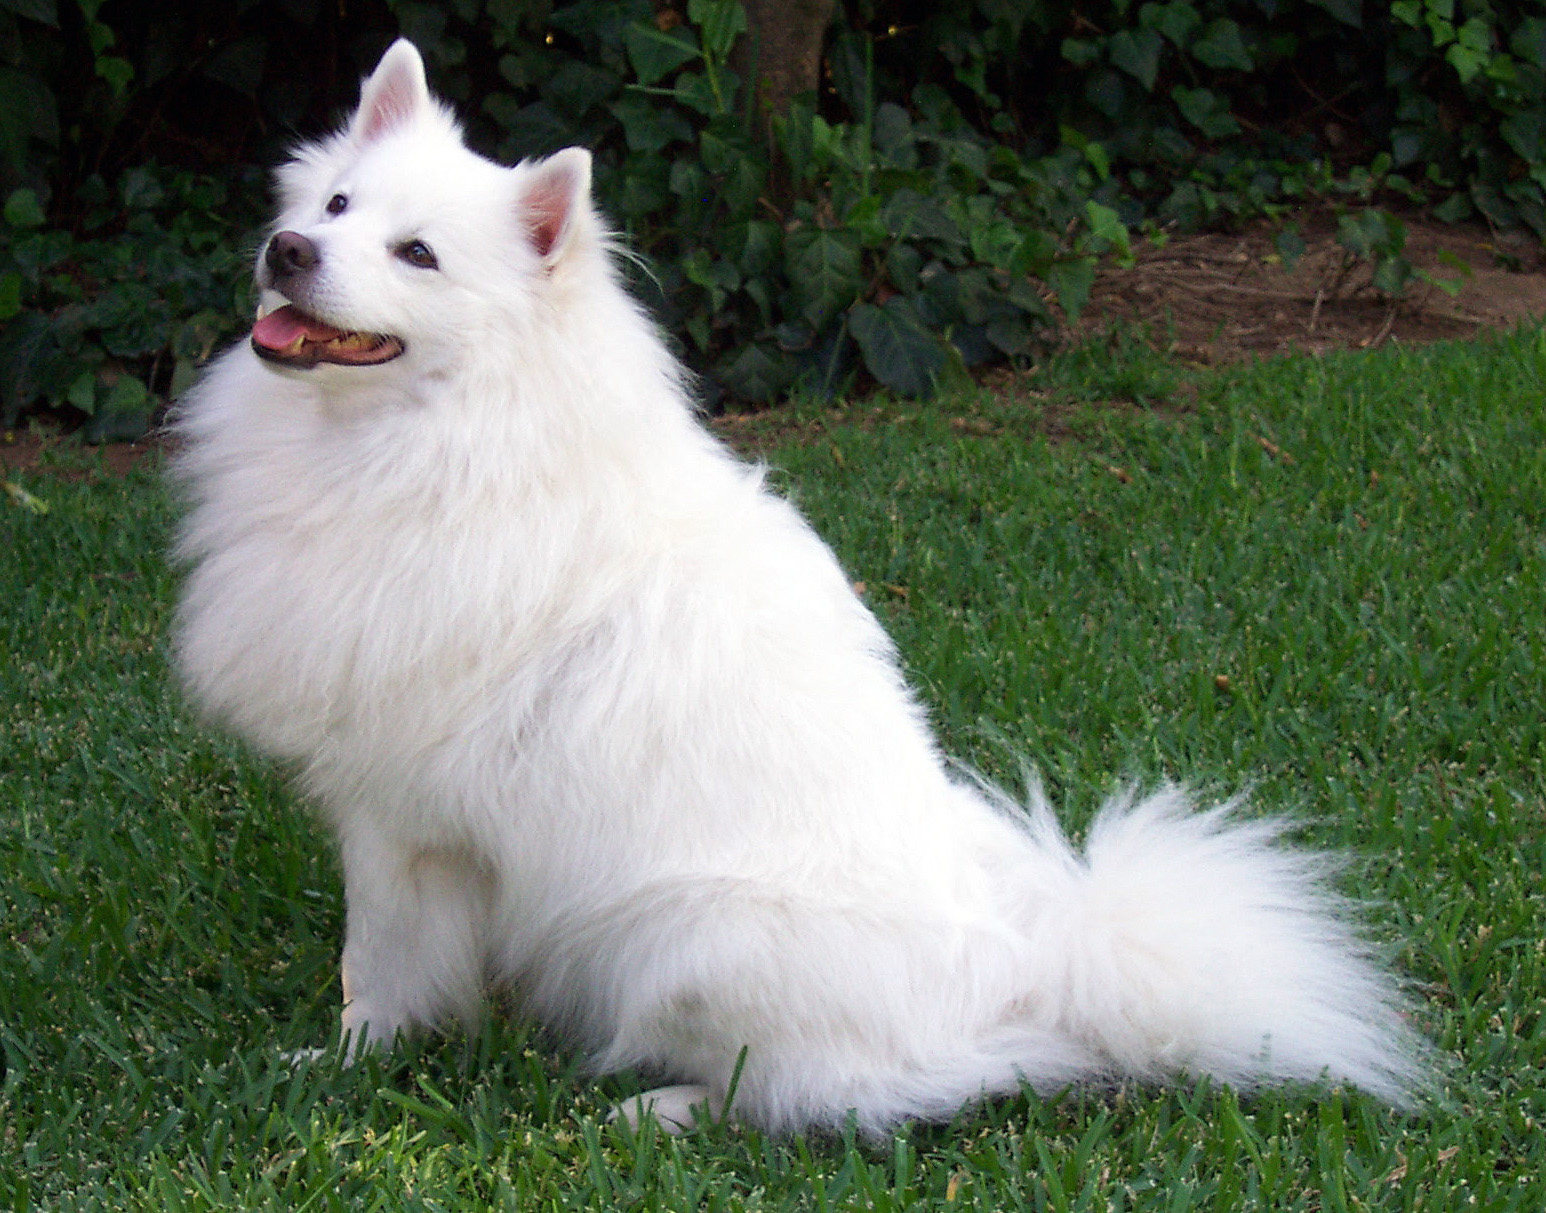

In [7]:
original_image

In [8]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
image_tensor = preprocess(original_image).unsqueeze(0)

In [10]:
summary(model.features, input_data=image_tensor)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─ConvBNActivation: 1-1                  [1, 16, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 16, 112, 112]         432
│    └─BatchNorm2d: 2-2                  [1, 16, 112, 112]         32
│    └─Hardswish: 2-3                    [1, 16, 112, 112]         --
├─InvertedResidual: 1-2                  [1, 16, 56, 56]           --
│    └─Sequential: 2-4                   [1, 16, 56, 56]           --
│    │    └─ConvBNActivation: 3-1        [1, 16, 56, 56]           176
│    │    └─SqueezeExcitation: 3-2       [1, 16, 56, 56]           280
│    │    └─ConvBNActivation: 3-3        [1, 16, 56, 56]           288
├─InvertedResidual: 1-3                  [1, 24, 28, 28]           --
│    └─Sequential: 2-5                   [1, 24, 28, 28]           --
│    │    └─ConvBNActivation: 3-4        [1, 72, 56, 56]           1,296
│    │  

In [11]:
to_pil_image = transforms.ToPILImage()

def get_hidden_layer_output(m, x):
    outputs = []
    with torch.no_grad():
        for layer in m:
            x = layer(x)
            outputs.append(x)
    return outputs

def min_div(n, x):
    x = int(x)
    while True:
        if n % x == 0:
            return  x
        if x > n:
            return n
        x += 1
        
def apply_cmap(image, cmap="viridis"):
    cm = plt.get_cmap(cmap)
    return Image.fromarray(np.uint8(cm(np.array(image.convert("L"))) * 255))

In [12]:
features = get_hidden_layer_output(model.features, image_tensor)

In [13]:
images = []
n = len(features)
for i in range(n):
    s = features[i].shape[1]
    nrow = min_div(s, np.sqrt(2 * s))
    images.append(
        apply_cmap(to_pil_image(
        torchvision.utils.make_grid(
    features[i].transpose(0, 1),
            nrow=nrow,
        ))) 
    )

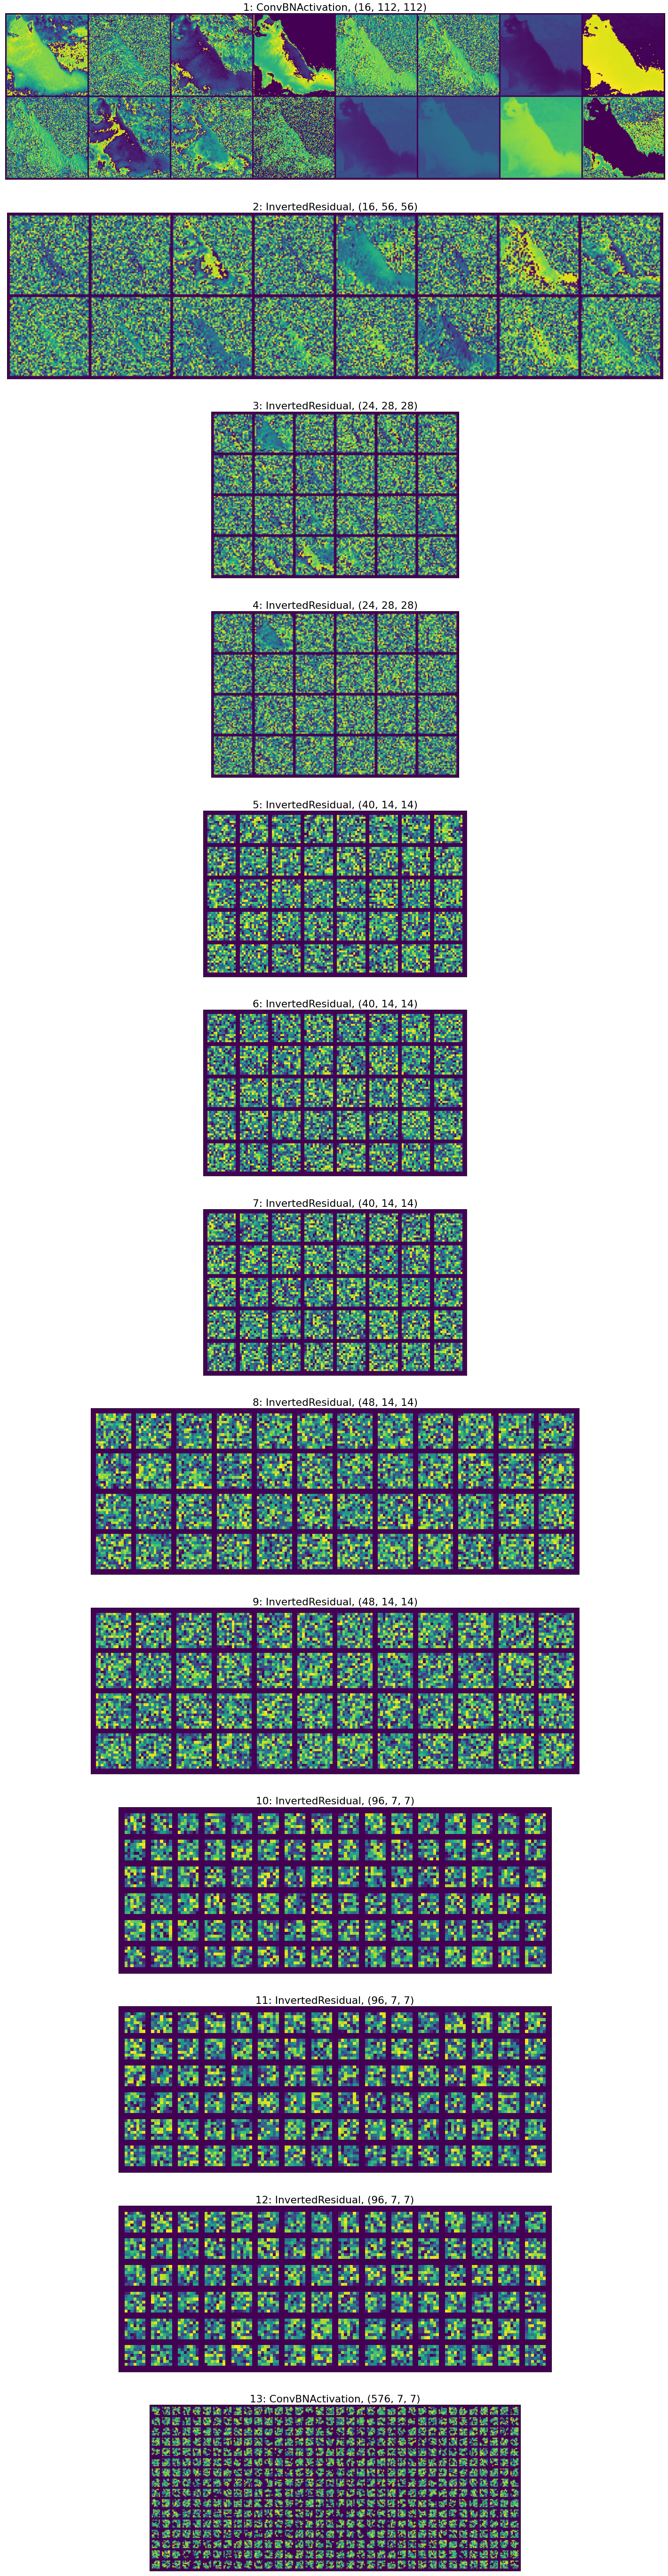

In [14]:
plt.rcParams["font.size"] = 18
fig, axes = plt.subplots(n, figsize=(30, 100))
for i in range(n):
    ax = axes[i]
    image = images[i]
    ax.imshow(image)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    shape = tuple(features[i].shape)[1:]
    name = model.features[i].__class__.__name__
    title = f"{i+1}: {name}, {shape}"
    ax.set_title(title)